<a href="https://colab.research.google.com/github/SyedHarshath/Computer-Vision/blob/main/Object_Detection_and_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Image Classification

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os

In [ ]:
dataset_path = "C:\\Users\\HARSHATH\\Downloads\\IMAGE"
categories = ["MS Dhoni","Kapil Dev","Sachin Tendulkar","Rahul Dravid","Virat Kohli"]

In [ ]:
def extract_hog_features(image):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (64,128))
    features,_ = hog(image,pixels_per_cell=(8,8),cells_per_block=(2,2),visualize=True)
    return features

def train_svm_classifier(dataset_path,categories):
    x,y = [],[]

    for label_index,label in enumerate(categories):
        folder_path = os.path.join(dataset_path,label)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} not found!")
            continue

        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path,filename)
            image = cv2.imread(image_path)
            if image is None:
                continue

            features = extract_hog_features(image)
            x.append(features)
            y.append(label_index)

    x = np.array(x)
    y = np.array(y)

    X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state = 42)
    svm = SVC(kernel='linear')
    svm.fit(X_train,y_train)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"SVM Accuracy : {accuracy:.2f}")

    return svm

def predict_image_class(image_path,svm_model):
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    if image is None:
        print("Error: Image not found.")
        return None

    features = extract_hog_features(image).reshape(1,-1)
    prediction = svm_model.predict(features)

    print(f"Predicted Class: {categories[prediction[0]]}")
    plt.imshow(image_gray,cmap='gray')
    plt.title(f"Predicted: {categories[prediction[0]]}")
    plt.axis('off')
    plt.show()

    return categories[prediction[0]]

SVM Accuracy : 0.61
Predicted Class: MS Dhoni


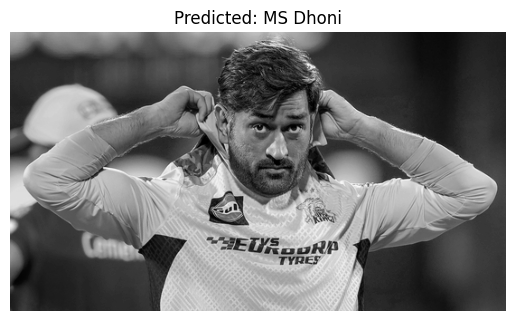

In [ ]:
svm_model = train_svm_classifier(dataset_path,categories)

test_image = "C:\\Users\\HARSHATH\\Downloads\\msdhoni.jpg"
if os.path.exists(test_image):
    predict_image_class(test_image,svm_model)
else:
    print("Error: Test image not found")

### Object Detection

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import color

In [ ]:
def compute_gloh_descriptors(image, keypoints, radius=16, angular_bins=8, radial_bins=3):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    descriptors = []
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        if x - radius < 0 or y - radius < 0 or x + radius >= gray.shape[1] or y + radius >= gray.shape[0]:
            continue
        patch = gray[y - radius:y + radius, x - radius:x + radius]
        gx = cv2.Sobel(patch, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(patch, cv2.CV_32F, 0, 1)
        magnitude = cv2.magnitude(gx, gy)
        angle = (cv2.phase(gx, gy, angleInDegrees=True)) % 360
        desc = []
        for r in range(1, radial_bins + 1):
            for t in range(angular_bins):
                mask = np.zeros_like(magnitude, dtype=np.uint8)
                for i in range(patch.shape[0]):
                    for j in range(patch.shape[1]):
                        dx = j - radius
                        dy = i - radius
                        rho = np.sqrt(dx ** 2 + dy ** 2)
                        theta = (np.degrees(np.arctan2(dy, dx)) + 360) % 360
                        if rho < (radius * r / radial_bins) and t * 360 / angular_bins <= theta < (t + 1) * 360 / angular_bins:
                            mask[i, j] = 1
                hist, _ = np.histogram(angle[mask == 1], bins=8, range=(0, 360), weights=magnitude[mask == 1])
                desc.extend(hist)
        desc = np.array(desc)
        if np.linalg.norm(desc) > 0:
            desc = desc / np.linalg.norm(desc)
        descriptors.append(desc)
    return descriptors

In [ ]:
def get_hog_image(image):
    gray = color.rgb2gray(image)
    fd, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, channel_axis=None)
    return hog_image

In [ ]:
query_img = cv2.imread('bat.jpg')
target_img = cv2.imread('msb.webp')

sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(query_img, None)
kp2, des2 = sift.detectAndCompute(target_img, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

MIN_MATCH_COUNT = 10
object_detected = False
if len(good_matches) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    if M is not None:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        transformed_pts = cv2.perspectiveTransform(src_pts, M)
        rect = cv2.minAreaRect(transformed_pts)
        box_points = cv2.boxPoints(rect)
        box_points = np.intp(box_points)
        detected_img = target_img.copy()
        maroon = (0, 0, 128)
        cv2.drawContours(detected_img, [box_points], 0, maroon, 5)
        object_detected = True
    else:
        detected_img = target_img.copy()

else:
    detected_img = target_img.copy()

hog_query = get_hog_image(query_img)
hog_target = get_hog_image(target_img)
gloh_descriptors = compute_gloh_descriptors(query_img, kp1)

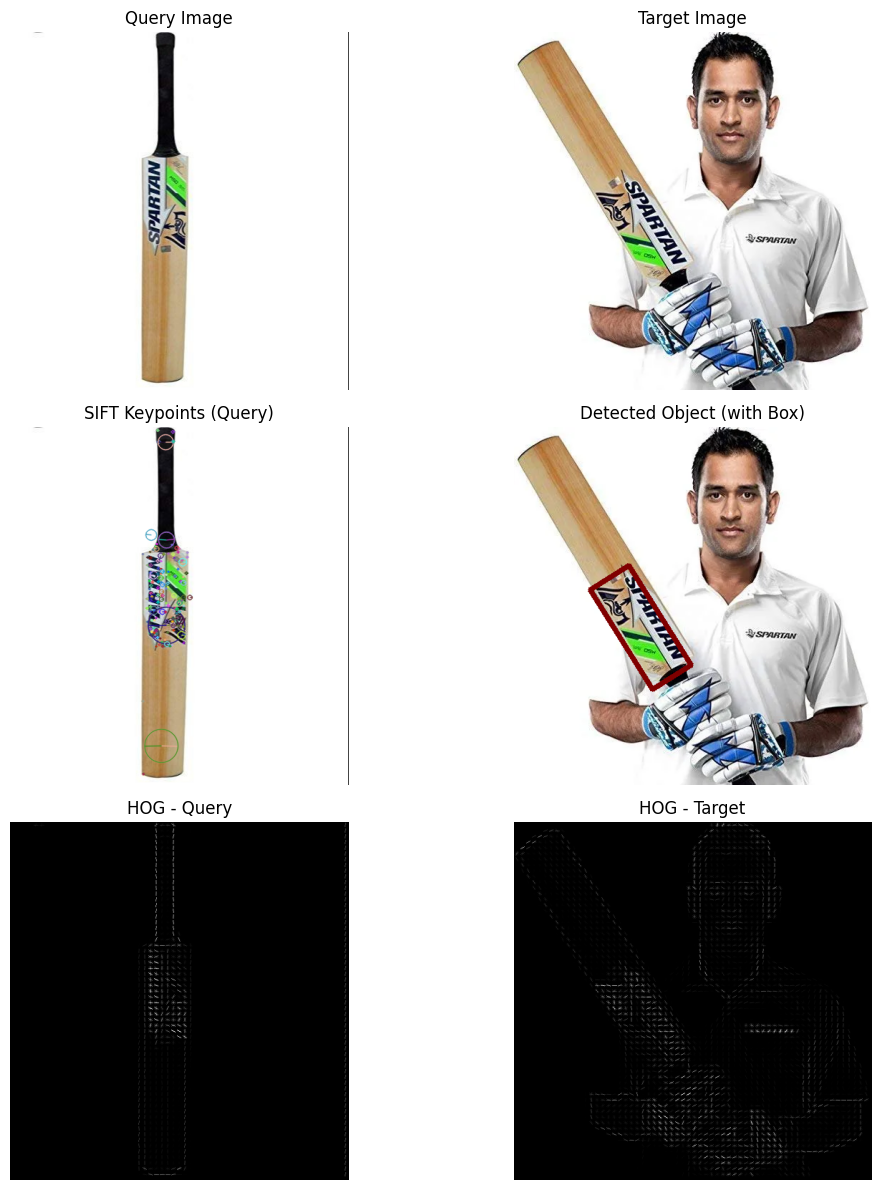

In [ ]:
plt.figure(figsize=(12, 12))

plt.subplot(3, 2, 1)
plt.imshow(cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB))
plt.title("Query Image")
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
plt.title("Target Image")
plt.axis('off')

img_kp1 = cv2.drawKeypoints(query_img, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.subplot(3, 2, 3)
plt.imshow(cv2.cvtColor(img_kp1, cv2.COLOR_BGR2RGB))
plt.title("SIFT Keypoints (Query)")
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB))
plt.title("Detected Object (with Box)" if object_detected else "Detection Failed")
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(hog_query, cmap='gray')
plt.title("HOG - Query")
plt.axis('off')

plt.subplot(3, 2, 6)
plt.imshow(hog_target, cmap='gray')
plt.title("HOG - Target")
plt.axis('off')

plt.tight_layout()
plt.show()

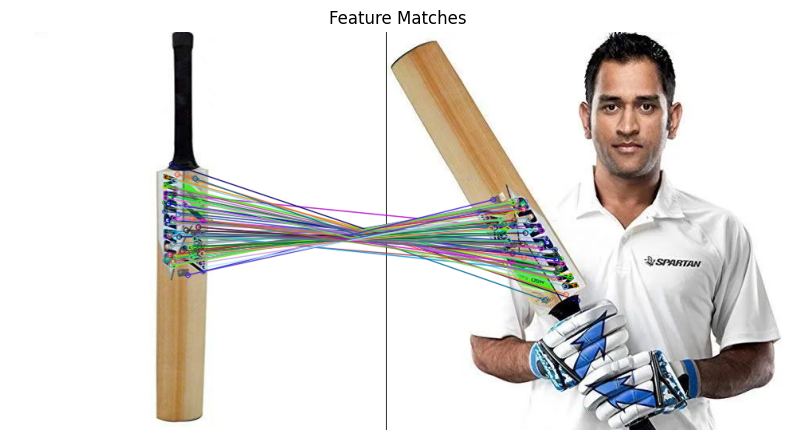

In [ ]:
match_img = cv2.drawMatches(query_img, kp1, target_img, kp2, good_matches, None, flags=2)
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.title("Feature Matches")
plt.axis('off')
plt.show()

In [ ]:
print(f"SIFT keypoints in query image: {len(kp1)}")
print(f"SIFT keypoints in target image: {len(kp2)}")
print(f"Object detected: {'Yes' if object_detected else 'No'}")
print(f"Number of GLOH descriptors: {len(gloh_descriptors)}")

SIFT keypoints in query image: 192
SIFT keypoints in target image: 1007
Object detected: Yes
Number of GLOH descriptors: 188
